# What is a distribution?

An object-oriented exploration of one of the most useful concepts in statistics.

Copyright 2016 Allen Downey

MIT License: http://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%matplotlib inline
%precision 6

import matplotlib.pyplot as plt

import numpy as np
from numpy.fft import fft, ifft

In [2]:
from inspect import getsourcelines

def show_code(func):
    lines, _ = getsourcelines(func)
    for line in lines:
        print(line, end='')

## Playing dice with the universe

One of the recurring themes of my books is the use of object-oriented programming to explore mathematical ideas.  Many mathematical entities are hard to define because they are so abstract.  Representing them in Python puts the focus on what operations each entity supports -- that is, what the objects can *do* -- rather than on what they *are*.

In this notebook, I explore the idea of a probability distribution, which is one of the most important ideas in statistics, but also one of the hardest to explain.

To keep things concrete, I'll start with one of the usual examples: rolling dice.  When you roll a standard six-sided die, there are six possible outcomes, the numbers 1 through 6, and all six outcomes are equally likely (at least approximately).

If you roll two dice and add up the total, there are 11 possible outcomes, the numbers 2 through 12, but they are not equally likely.  The least likely outcomes, 2 and 12, only happen once in 36 tries; the most likely outcome happens 1 times in 6.

And if you roll three dice and add them up, you get a different set of possible outcomes with a different set of probabilities.

What I've just described are three random number generators, which are also called **random processes**.  The output from a random process is a **random variable**, or more generally a set of random variables.  And each random variable has **probability distribution**, which is the set of possible outcomes and the corresponding set of probabilities.

There are many ways to represent a probability distribution.  The most obvious is a **probability mass function**, or PMF, which is a function that maps from each possible outcome to its probability.  And in Python, the most obvious way to represent a PMF is with a dictionary that maps from outcomes to probabilities.

Here's a definition for a class named `Pmf` that represents a PMF.

In [3]:
class Pmf:
    
    def __init__(self, d=None):
        """Initializes the distribution.

        d: map from values to probabilities
        """
        self.d = {} if d is None else d

    def items(self):
        """Returns a sequence of (value, prob) pairs."""
        return self.d.items()
    
    def __repr__(self):
        """Returns a string representation of the object."""
        cls = self.__class__.__name__
        return '%s(%s)' % (cls, repr(self.d))

    def __getitem__(self, value):
        """Looks up the probability of a value."""
        return self.d.get(value, 0)

    def __setitem__(self, value, prob):
        """Sets the probability associated with a value."""
        self.d[value] = prob

    def __add__(self, other):
        """Computes the Pmf of the sum of values drawn from self and other.

        other: another Pmf or a scalar

        returns: new Pmf
        """
        pmf = Pmf()
        for v1, p1 in self.items():
            for v2, p2 in other.items():
                pmf[v1 + v2] += p1 * p2
        return pmf
    
    def total(self):
        """Returns the total of the probabilities."""
        return sum(self.d.values())

    def normalize(self):
        """Normalizes this PMF so the sum of all probs is 1.

        Args:
            fraction: what the total should be after normalization

        Returns: the total probability before normalizing
        """
        total = self.total()
        for x in self.d:
            self.d[x] /= total
        return total
    
    def mean(self):
        """Computes the mean of a PMF."""
        return sum(p * x for x, p in self.items())

    def var(self, mu=None):
        """Computes the variance of a PMF.

        mu: the point around which the variance is computed;
                if omitted, computes the mean
        """
        if mu is None:
            mu = self.mean()

        return sum(p * (x - mu) ** 2 for x, p in self.items())

    def expect(self, func):
        """Computes the expectation of a given function, E[f(x)]

        func: function
        """
        return sum(p * func(x) for x, p in self.items())

    def display(self):
        """Displays the values and probabilities."""
        for value, prob in self.items():
            print(value, prob)
            
    def plot_pmf(self, **options):
        """Plots the values and probabilities."""
        xs, ps = zip(*sorted(self.items()))
        plt.plot(xs, ps, **options)

Each `Pmf` contains a dictionary named `d` that contains the values and probabilities.  To show how this class is used, I'll create a `Pmf` that represents a six-sided die:

In [4]:
d6 = Pmf()
for x in range(1, 7):
    d6[x] = 1

d6

Pmf({1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1})

`Pmf` provides a `display` method that's easier to read:

In [5]:
d6.display()

1 1
2 1
3 1
4 1
5 1
6 1


Initially the "probabilities" are all 1, so the total probability in the `Pmf` is 6, which doesn't make a lot of sense.  In a proper, meaningful, Pmf, the probabilities add up to 1, which means that we know that one outcome, and only one outcome, will occur (for any given roll of the die).

We can take this "unnormalized" distribution and make it a proper `Pmf` using the `normalize` method.  Here's what the method looks like:

In [6]:
show_code(Pmf.normalize)

    def normalize(self):
        """Normalizes this PMF so the sum of all probs is 1.

        Args:
            fraction: what the total should be after normalization

        Returns: the total probability before normalizing
        """
        total = self.total()
        for x in self.d:
            self.d[x] /= total
        return total


And here's how it's used:

In [7]:
d6.normalize()
d6.display()

1 0.16666666666666666
2 0.16666666666666666
3 0.16666666666666666
4 0.16666666666666666
5 0.16666666666666666
6 0.16666666666666666


The fundamental operation provided by a `Pmf` is a "lookup"; that is, we can look up an outcome and get the corresponding probability.  `Pmf` provides `__getitem__`, so we can use bracket notation to look up an outcome:

In [8]:
d6[3]

0.166667

And if you look up a value that's not in the `Pmf`, the probability is 0.

In [9]:
d6[7]

0

## Is that all there is?

So is a `Pmf` a distribution?  No.  At least in this framework, a `Pmf` is one of several representations of a distribution.  Other representations include the **cumulative distribution function**, or CDF, and the **characteristic function**.  I'll explain both of these below.

These representations are equivalent in the sense that they all contain the same informaton; if I give you any one of them, you can figure out the others (and we'll see how soon).

So why would we want different representations of the same information?  The fundamental reason is that there are many different operations we would like to perform with distributions -- that is, questions we would like to answer.  Some representations are better for some operations, but none of them is the best for all operations.  In the context of computation, what I mean by "better" includes both easier to implement and more efficient.

So what are the questions we would like a distribution to answer?  They include:

*  What is the probability of a given outcome?
*  What is the mean of the outcomes, taking into account their probabilities?
*  What is the variance, and other moments, of the outcome?
*  What is the probability that the outcome exceeds (or falls below) a threshold?
*  What is the median of the outcomes, that is, the 50th percentile?
*  What are the other percentiles?
*  How can get generate a random sample from this distribution, with the appropriate probabilities?
*  If we run two random processes and choose the maximum of the outcomes (or minimum), what is the distribution of the result?
*  If we run two random processes and add up the results, what is the distribution of the sum?

Each of these questions corresponds to a method we would like a distribution to provide.  But as I said, there is no one representation that answers all of them well.  So let's look at the different representations and see what they can do.

Getting back to the `Pmf`, we've already seen how to look up the probability of a given outcome.  Here's the code:

In [10]:
show_code(Pmf.__getitem__)

    def __getitem__(self, value):
        """Looks up the probability of a value."""
        return self.d.get(value, 0)


Python dictionaries are implemented using hash tables, so we expect `get` to be fast.  In terms of algorithmic complexity, it is constant time, or $O(1)$.

## Moments and expecations

Pmfs are also good for computing mean, variance, and other moments.  Here's the implementation of `Pmf.mean`:

In [11]:
show_code(Pmf.mean)

    def mean(self):
        """Computes the mean of a PMF."""
        return sum(p * x for x, p in self.items())


This implementation is efficient, in the sense that it is $O(n)$, and because it uses a comprehension to traverse the outcomes, the overhead is low. 

The implementation of `Pmf.var` is similar:

In [12]:
show_code(Pmf.var)

    def var(self, mu=None):
        """Computes the variance of a PMF.

        mu: the point around which the variance is computed;
                if omitted, computes the mean
        """
        if mu is None:
            mu = self.mean()

        return sum(p * (x - mu) ** 2 for x, p in self.items())


And here's how they are used:

In [13]:
d6.mean(), d6.var()

(3.500000, 2.916667)

The structure of `mean` and `var` is the same: they traverse the outcomes and their probabilities, `x` and `p`, and add up the product of `p` and some function of `x`.

We can generalize this structure to compute the **expectation** for any function of `x`.  `Pmf` provides `expect`, which takes a function object, `func`, and returns the expectation of `func(x)`, or $E[X]$:

In [14]:
show_code(Pmf.expect)

    def expect(self, func):
        """Computes the expectation of a given function, E[f(x)]

        func: function
        """
        return sum(p * func(x) for x, p in self.items())


As an example, we can use `expect` to compute the third central moment of the distribution: 

In [15]:
mu = d6.mean()
d6.expect(lambda x: (x-mu)**3)

0.000000

Because the distribution is symmetric, the third central moment is 0.

## Addition

The next question we'll answer is the last one on the list: if we run two random processes and add up the results, what is the distribution of the sum?  In other words, if the result of the first process is a random variable, $X$, and the result of the second is $Y$, what is the distribution of $X+Y$?

The `Pmf` representation of the distribution can answer this question pretty well, but we'll see later that the characteristic function is even better.

Here's the implementation in `Pmf`:

In [16]:
show_code(Pmf.__add__)

    def __add__(self, other):
        """Computes the Pmf of the sum of values drawn from self and other.

        other: another Pmf or a scalar

        returns: new Pmf
        """
        pmf = Pmf()
        for v1, p1 in self.items():
            for v2, p2 in other.items():
                pmf[v1 + v2] += p1 * p2
        return pmf


The outer loop traverses the outcomes and probabilities of the first `Pmf`; the inner loop traverses the second `Pmf`.  Each time through the loop, we compute the sum of the outcome pair and the probability that the pair occurs.

Note that this method implicitly assumes that the two processes are independent; that is, the outcome from one does not affect the other.  That's why we can compute the probability of the pair by multiplying the probabilities of the outcomes.

To demonstrate this method, we'll start with `d6` again.  Here's what it looks like:

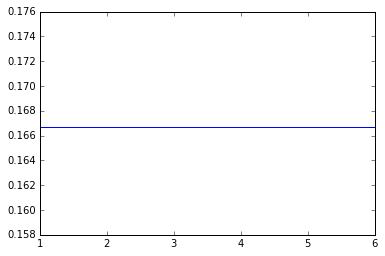

In [17]:
d6.plot_pmf()

When we use the `+` operator, Python invokes the `__add__` method, which returns a new `Pmf` object.  Here's the `Pmf` that represents the sum of two dice:

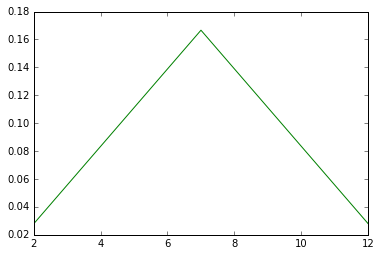

In [18]:
twice = d6 + d6
twice.plot_pmf(color='green')

And here's the `Pmf` that represents the sum of three dice.

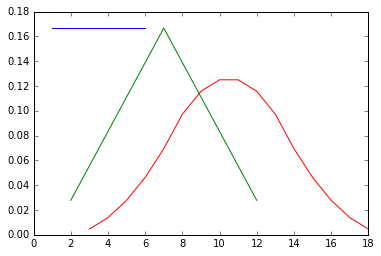

In [19]:
thrice = twice + d6
d6.plot_pmf()
twice.plot_pmf()
thrice.plot_pmf()

As we add up more dice, the result converges to the bell shape of the Gaussian, or normal, distribution.

## Cumulative probabilities

The next few questions on the list are harder to answer with the `Pmf` representation, but easier with a **cumulative distribution function** (CDF).

A CDF is a map from an outcome, $x$, to its cumulative probability, which is the probability that the outcome is less than or equal to $x$.  In math notation:

$CDF(x) = Prob(X \le x)$

where $X$ is the outcome of a random process, and $x$ is the threshold we are interested in.  For example, if $CDF$ is the cumulative distribution for the sum of three dice, the probability of getting 5 or less is $CDF(5)$, and the probability of getting 6 or more is $1 - CDF(5)$.

To represent a CDF in Python, I use a sorted list of outcomes and the corresponding list of cumulative probabilities.

In [20]:
class Cdf:
    
    def __init__(self, xs, ps):
        self.xs = xs
        self.ps = ps

    def __repr__(self):
        return 'Cdf(%s, %s)' % (repr(self.xs), repr(self.ps))

    def __getitem__(self, x):
        return self.cumprobs([x])[0]
    
    def cumprobs(self, values):
        """Gets probabilities for a sequence of values.

        values: any sequence that can be converted to NumPy array

        returns: NumPy array of cumulative probabilities
        """
        values = np.asarray(values)
        index = np.searchsorted(self.xs, values, side='right')
        ps = self.ps[index-1]
        ps[values < self.xs[0]] = 0.0
        return ps

    def values(self, ps):
        """Returns InverseCDF(p), the value that corresponds to probability p.

        ps: sequence of numbers in the range [0, 1]

        returns: NumPy array of values
        """
        ps = np.asarray(ps)
        if np.any(ps < 0) or np.any(ps > 1):
            raise ValueError('Probability p must be in range [0, 1]')

        index = np.searchsorted(self.ps, ps, side='left')
        return self.xs[index]
    
    def sample(self, shape):
        """Generates a random sample from the distribution.
        
        shape: dimensions of the resulting NumPy array
        """
        ps = np.random.random(shape)
        return self.values(ps)
    
    def maximum(self, k):
        """Computes the CDF of the maximum of k samples from the distribution."""
        return Cdf(self.xs, self.ps**k)
    
    def display(self):
        """Displays the values and cumulative probabilities."""
        for x, p in zip(self.xs, self.ps):
            print(x, p)
            
    def plot_cdf(self, **options):
        """Plots the cumulative probabilities."""
        plt.plot(self.xs, self.ps, **options)

`compute_cumprobs` takes a dictionary that maps outcomes to probabilities, sorts the outcomes in increasing order, then makes two NumPy arrays: `xs` is the sorted sequence of values; `ps` is the sequence of cumulative probabilities:

In [21]:
def compute_cumprobs(d):
    xs, freqs = zip(*sorted(d.items()))
    xs = np.asarray(xs)
    ps = np.cumsum(freqs, dtype=np.float)
    ps /= ps[-1]
    return xs, ps

In [22]:
xs, ps = compute_cumprobs(thrice.d)
cdf = Cdf(xs, ps)
cdf.display()

3 0.00462962962963
4 0.0185185185185
5 0.0462962962963
6 0.0925925925926
7 0.162037037037
8 0.259259259259
9 0.375
10 0.5
11 0.625
12 0.740740740741
13 0.837962962963
14 0.907407407407
15 0.953703703704
16 0.981481481481
17 0.99537037037
18 1.0


Now we can compute $CDF(x)$ by searching the `xs` to find the right location, or index, and the looking up the corresponding probability.  Because the `xs` are sorted, we can use bisection search, which is $O(\log n)$.

`Cdf` provides `cumprobs`, which takes an array of values and returns the corresponding probabilities:

In [23]:
show_code(Cdf.cumprobs)

    def cumprobs(self, values):
        """Gets probabilities for a sequence of values.

        values: any sequence that can be converted to NumPy array

        returns: NumPy array of cumulative probabilities
        """
        values = np.asarray(values)
        index = np.searchsorted(self.xs, values, side='right')
        ps = self.ps[index-1]
        ps[values < self.xs[0]] = 0.0
        return ps


The details here are a little tricky because we have to deal with some "off by one" problems, and if any of the values are less than the smallest value in the `Cdf`, we have to handle that as a special case.  But the basic idea is simple, and the implementation is efficient.

To show how it's used, I'll compute the `Cdf` for the sum of three dice.

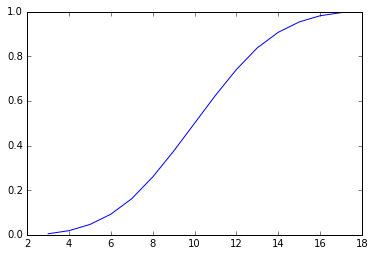

In [24]:
cdf.plot_cdf()

Now we can look up probabilities for a sequence of values:

In [25]:
cdf.cumprobs((2, 10, 18))

array([ 0. ,  0.5,  1. ])

`Cdf` also provides `__getitem__`, so we can use brackets to look up a single value:

In [26]:
cdf[5]

0.046296

## Reverse lookup

You might wonder why I represent a `Cdf` with two lists rather than a dictionary.  After all, a dictionary lookup is constant time and bisection search is logarithmic.  The reason is that we often want to use a `Cdf` to do a reverse lookup; that is, given a probability, we would like to find the corresponding value.  With two sorted lists, a reverse lookup has the same performance as a forward loopup, $O(\log n)$.

Here's the implementation:

In [27]:
show_code(Cdf.values)

    def values(self, ps):
        """Returns InverseCDF(p), the value that corresponds to probability p.

        ps: sequence of numbers in the range [0, 1]

        returns: NumPy array of values
        """
        ps = np.asarray(ps)
        if np.any(ps < 0) or np.any(ps > 1):
            raise ValueError('Probability p must be in range [0, 1]')

        index = np.searchsorted(self.ps, ps, side='left')
        return self.xs[index]


And here's an example that finds the 25th, 50th, and 75th percentiles:

In [28]:
cdf.values((.25, .5, .75))

array([ 8, 10, 13])

The `Cdf` representation is also good at generating random samples, by choosing a probability uniformly from 0 to 1 and finding the corresponding value.  Here's the method `Cdf` provides:

In [29]:
show_code(Cdf.sample)

    def sample(self, shape):
        """Generates a random sample from the distribution.
        
        shape: dimensions of the resulting NumPy array
        """
        ps = np.random.random(shape)
        return self.values(ps)


The result is a NumPy array with the given `shape`.  The time to generate each random choice is $O(\log n)$

Here are some examples that use it.

In [30]:
cdf.sample(1)

array([12])

In [31]:
cdf.sample(6)

array([13, 14,  5, 12,  8,  7])

In [32]:
cdf.sample((2, 2))

array([[14, 11],
       [13, 11]])

## Max and min

The `Cdf` representation is particularly good for finding the distribution of a maximum.  For example, in Dungeons and Dragons, players generate random characteristics by rolling three dice and adding them, so the CDF for each characteristic is the `Cdf` we used in this example.  Each player gets six characteristics, so we might wonder what the distribution is for the best of the six.

Here's the method that computes it:



In [33]:
show_code(Cdf.maximum)

    def maximum(self, k):
        """Computes the CDF of the maximum of k samples from the distribution."""
        return Cdf(self.xs, self.ps**k)


To get the distribution of the maximum, we make a copy of the `Cdf` and raise the `ps` to the `k`th power.  Amazingly simple, isn't it?

To see how it works, suppose you generate six characteristics and your best characteristic is only a 10.  That's unlucky, but you might wonder how unlucky.  So, what the chance of rolling 3 dice six times, and never getting anything better than 10?

Well, that means that all six values were 10 or less.  The probability that each of them is 10 or less is $CDF(10)$, because that's what the CDF means.

So the probability that all 6 are 10 or less is $CDF(10)^6$.  And we can generalize that by replacing $10$ with any value of $x$, and replacing $6$ with any integer $k$.

Conclusion: the CDF of the maximum, which the probability that all $k$ rolls are $x$ or less, is $CDF(x)^k$.

Here's how we use `Cdf.maximum`:

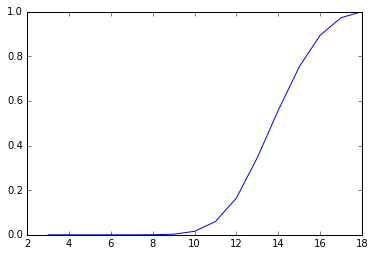

In [34]:
best = cdf.maximum(6)
best.plot_cdf()

And here's how we can use the result to get the percentiles of the maximum:

In [35]:
best.values([0.25, 0.5, 0.75])

array([13, 14, 15])

You can use a similar method to find the distribution of the minimum.  I'll leave that as an exercise.

## Characteristic function

At this point we've answered all the questions on the list, but I want to come back to addition, because the algorithm we used with the `Pmf` representation is not as efficient as it could be.  It enumerates all pairs of outcomes, so if there are $n$ values in each `Pmf`, the run time is $O(n^2)$.  We can do better.

The key is the **characteristic function**, which is the Fourier transform (FT) of the PMF.  If you are familiar with the Fourier transform and the Convolution Theorem, keep reading.  Otherwise, skip the rest of this cell and get to the code, which is much simpler than the explanation.

### Details for people who know about convolution

If you are familiar with the FT in the context of spectral analysis of signals, you might wonder why we would possibly want to compute the FT of a PMF.  The reason is the Convolution Theorem.

It turns out that the algorithm we used to "add" two `Pmf` objects is a form of convolution.  To see how that works, suppose we are computing the distribution of $Z = X+Y$.  To make things concrete, let's compute the probability that the sum, $Z$ is 5.  To do that, we can enumerate all possible values of $X$ like this:

$Prob(Z=5) = \sum_x Prob(X=x) \cdot Prob(Y=5-x)$

Now we can write each of those probabilities in terms of the PMF of $X$, $Y$, and $Z$:

$PMF_Z(5) = \sum_x PMF_X(x) \cdot PMF_Y(5-x)$

And now we can generalize by replacing 5 with any value of $z$:

$PMF_Z(z) = \sum_x PMF_X(x) \cdot PMF_Y(z-x)$

And you might recognize that computation as convolution, denoted with the operator $\ast$.  Now, according to the Convolution Theorem:

$FT(X \ast Y) = FT(X) \cdot FT(Y)$

Or, taking the inverse FT of both sides:

$X \ast Y = IFT(FT(X) \cdot FT(Y))$

In words, to compute the convolution of $X$ and $Y$, we can compute the FT of $X$ and $Y$ and multiply them together, the compute the inverse FT of the result.

Let's see how that works.  Here's a class that represents a characteristic function.

In [36]:
class CharFunc:
    
    def __init__(self, hs):
        """Initializes the CF.
        
        hs: NumPy array of complex
        """
        self.hs = hs

    def __mul__(self, other):
        """Computes the elementwise product of two CF."""
        return CharFunc(self.hs * other.hs)
        
    def make_pmf(self, thresh=1e-11):
        """Converts a characteristic function to PMF.
        
        Values with probabilities below `thresh` are dropped.
        """
        ps = ifft(self.hs)
        d = dict((i, p) for i, p in enumerate(ps.real) if p > thresh)
        return Pmf(d)
    
    def plot_cf(self, **options):
        """Plots the real and imaginary parts of the CF."""
        n = len(self.hs)
        xs = np.arange(-n//2, n//2)
        hs = np.roll(self.hs, len(self.hs) // 2)
        plt.plot(xs, hs.real, label='real', **options)
        plt.plot(xs, hs.imag, label='imag', **options)
        plt.legend()

The attribute, `hs`, is the Fourier transform of the `Pmf` as a NumPy array of complex numbers.

The following function takes a dictionary that maps from outcomes to their probabilities, and computes the characteristic function:

In [37]:
def compute_fft(d, n=256):
    """Computes the FFT of a PMF of integers.
    
    Values must be integers less than `n`.
    """
    xs, freqs = zip(*d.items())
    ps = np.zeros(256)
    ps[xs,] = freqs
    hs = fft(ps)
    return hs

`fft` computes the Fast Fourier Transform (FFT), which is called "fast" because the run time is $O(n \log n)$.

Here's what the characteristic function looks like for the sum of three dice (plotting the real and imaginary parts of `hs`):

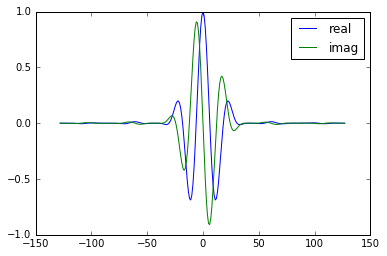

In [38]:
hs = compute_fft(thrice)
cf = CharFunc(hs)
cf.plot_cf()

The characteristic function contains all of the information from the `Pmf`, but it is encoded in a form that is hard to interpret (however, if you plot the magnitude of the `hs`, it might look familiar).

If we are given a characteristic function, we can find the corresponding `Pmf`.
`CharFunc` provides `make_pmf`, which uses the inverse FFT to get back to the `Pmf` representation.  Here's the code:

In [39]:
show_code(CharFunc.make_pmf)

    def make_pmf(self, thresh=1e-11):
        """Converts a characteristic function to PMF.
        
        Values with probabilities below `thresh` are dropped.
        """
        ps = ifft(self.hs)
        d = dict((i, p) for i, p in enumerate(ps.real) if p > thresh)
        return Pmf(d)


And here's an example:

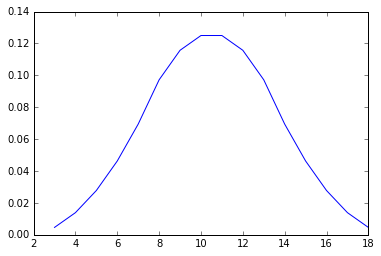

In [40]:
cf.make_pmf().plot_pmf()

Now we can use the characteristic function to compute a convolution.  `CharFunc` provides `__mul__`, which multiplies the `hs` elementwise and returns a new `CharFunc` object:

In [41]:
show_code(CharFunc.__mul__)

    def __mul__(self, other):
        """Computes the elementwise product of two CF."""
        return CharFunc(self.hs * other.hs)


And here's how we can use it to compute the distribution of the sum of 6 dice.

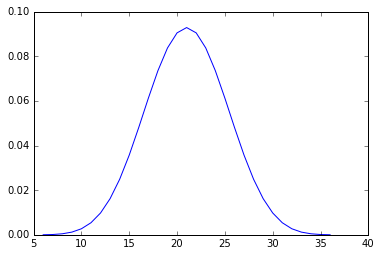

In [42]:
sixth = (cf * cf).make_pmf()
sixth.plot_pmf()

And here are the probabilities, mean, and variance.

In [43]:
sixth.display()

6 2.14334705076e-05
7 0.000128600823045
8 0.000450102880659
9 0.00120027434842
10 0.00270061728395
11 0.0054012345679
12 0.00977366255144
13 0.0162037037037
14 0.0248842592593
15 0.0357081618656
16 0.0481610082305
17 0.0612139917695
18 0.0735382373114
19 0.0837191358025
20 0.0904706790123
21 0.0928497942387
22 0.0904706790123
23 0.0837191358025
24 0.0735382373114
25 0.0612139917695
26 0.0481610082305
27 0.0357081618656
28 0.0248842592593
29 0.0162037037037
30 0.00977366255144
31 0.0054012345679
32 0.00270061728395
33 0.00120027434842
34 0.000450102880658
35 0.000128600823045
36 2.14334705075e-05


In [44]:
sixth.mean(), sixth.var()

(21.000000, 17.500000)

This might seem like a roundabout way to compute a convolution, but it is efficient.  The time to Compute the `CharFunc` objects is $O(n \log n)$.  Multiplying them together is $O(n)$.  And converting back to a `Pmf` is $O(n \log n)$.

So the whole process is $O(n \log n)$, which is better than `Pmf.__add__`, which is $O(n^2)$.

## Distributions

Let's back to the question we started with: *what is a distribution?*

I've said that `Pmf`, `Cdf`, and `CharFunc` are different ways to represent the same information.  For the questions we want to answer, some representations are better than others.  But how should we represent the distribution itself?

One option is to treat each representation as a **mixin**; that is, a class that provides a set of capabilities.  A distribution inherits all of the capabilities from all of the representations.  Here's a class that shows what I mean:

In [45]:
class Dist(Pmf, Cdf, CharFunc):
    
    def __init__(self, d):
        Pmf.__init__(self, d)
        Cdf.__init__(self, *compute_cumprobs(d))
        CharFunc.__init__(self, compute_fft(d))
        
    def __add__(self, other):
        pmf = Pmf.__add__(self, other)
        return Dist(pmf.d)
    
    def __mul__(self, other):
        pmf = CharFunc.__mul__(self, other).make_pmf()
        return Dist(pmf.d)

When you create a `Dist`, you provide a dictionary of values and probabilities.  `Dist.__init__` calls the other three `__init__` methods to create the `Pmf`, `Cdf`, and `CharFunc` representations.  The result is an object that has all the attributes and methods of the three representations.

As an example, I'll create a `Dist` that represents the sum of six dice:

In [46]:
dist = Dist(sixth.d)
dist.display()

6 2.14334705076e-05
7 0.000128600823045
8 0.000450102880659
9 0.00120027434842
10 0.00270061728395
11 0.0054012345679
12 0.00977366255144
13 0.0162037037037
14 0.0248842592593
15 0.0357081618656
16 0.0481610082305
17 0.0612139917695
18 0.0735382373114
19 0.0837191358025
20 0.0904706790123
21 0.0928497942387
22 0.0904706790123
23 0.0837191358025
24 0.0735382373114
25 0.0612139917695
26 0.0481610082305
27 0.0357081618656
28 0.0248842592593
29 0.0162037037037
30 0.00977366255144
31 0.0054012345679
32 0.00270061728395
33 0.00120027434842
34 0.000450102880658
35 0.000128600823045
36 2.14334705075e-05


We get the `__getitem__` method from `Pmf`, so we can look up the probability of a value.

In [47]:
dist[30]

0.009774

And compute mean and variance:

In [48]:
dist.mean(), dist.var()

(21.000000, 17.500000)

But we can also use methods from `Cdf`, like `values`:

In [49]:
dist.values((0.25, 0.5, 0.75))

array([18, 21, 24])

And `cumprobs`

In [50]:
dist.cumprobs((18, 21, 24))

array([ 0.279385,  0.546425,  0.794153])

And `sample`

In [51]:
dist.sample(10)

array([19, 21, 20, 16, 20, 27, 17, 25, 28, 23])

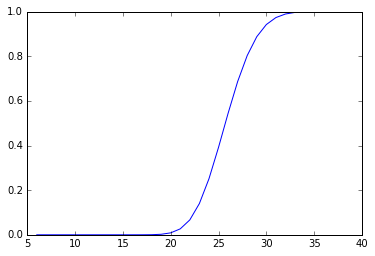

In [52]:
dist.maximum(6).plot_cdf()

`Dist.__add__` uses `Pmf.__add__`, which performs convolution the slow way:

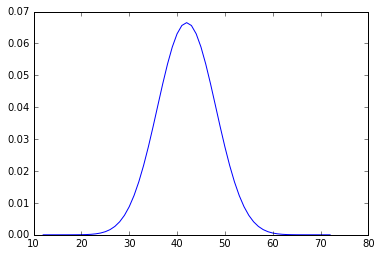

In [53]:
twelfth = dist + dist
twelfth.plot_pmf()

In [54]:
twelfth.mean()

42.000000

`Dist.__mul__` uses `CharFunc.__mul__`, which performs convolution the fast way.

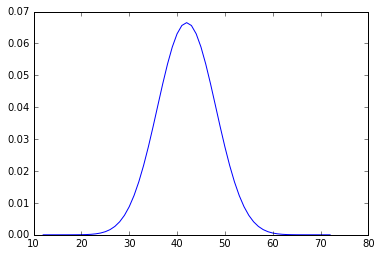

In [55]:
twelfth_fft = dist * dist
twelfth_fft.plot_pmf()

In [56]:
twelfth_fft.mean()

42.000000

Either way, we get the right answer, which is 42, of course.

## Summary

Abstractly, a distribution is an entity that can answer questions about the outcomes of random variables and their probabilities.  There are many ways to represent a distribution; each representation is equivalent to the others in the sense that they contain the same information, and you can convert from any of them to the others.  

Some representations make it easy and efficient to answer some questions, but none of the representations is best for all of the questions.

In my implementation, a `Dist` object has the attributes and methods of all representations.  From a software engineering point of view, that might not be the best design, but it is meant to illustrate what it means to be a distribution.

In short, if you give me any representation of a distribution, you have told me everything I need to know to answer questions about the possible outcomes and their probabilities.  Converting from one representation to another is mostly a matter of convenience and computational efficiency.

Conversely, if you are trying to find the distribution of a random variable, you can do it by computing whichever representation is easiest to figure out.